# VAE and VSC for Cell Images

In [1]:
import torch
from torch import cuda
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils import data
from torchvision.utils import save_image
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
data_dir = '../../../Data/'
results_dir = '../../../results/'
batch_size = 128

torch.manual_seed(22)
device = torch.device("cuda" if cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.0302, 0.0660, 0.0518])
    std = np.array([0.0633, 0.0974, 0.0766])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15,15))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

## VAE - Existing Work
First the VAE that was already developed was migrated from Tensorflow to Pytorch
before starting to work on the VSC

In [4]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        channels = 'placeholder'
        # Encoder
        self.encoder_conv1 = self.getConvolutionLayer(3, 128)
        self.encoder_conv2 = self.getConvolutionLayer(128, 64)
        self.encoder_conv3 = self.getConvolutionLayer(64, 32)
        
        self.flatten = nn.Flatten()

        self.encoder_fc1 = nn.Linear(4608, self.latent_dim)
        self.encoder_fc2 = nn.Linear(4608, self.latent_dim)
        
        # Decoder
        self.decoder_fc1 = nn.Sequential(
            nn.Linear(self.latent_dim, 4608),
            nn.ReLU()
        )
        # Reshape to 32x12x12
        self.decoder_upsampler1 = nn.Upsample(scale_factor=(2,2) ,mode='nearest')
        
        self.decoder_deconv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.Upsample(scale_factor=(2,2) ,mode='nearest')
        )
        # 48x48x64
        self.decoder_deconv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.Upsample(scale_factor=(2,2) ,mode='nearest')
        )

        self.decoder_conv1 = nn.Conv2d(in_channels=128, out_channels=3, kernel_size=3, stride=1, padding=1)
        # 96x96x128
        

    def getConvolutionLayer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )


    def encode(self, x):
        x = self.encoder_conv1(x)
        x = self.encoder_conv2(x)
        x = self.encoder_conv3(x)
        
        x = self.flatten(x)
        mu = self.encoder_fc1(x)
        sigma = self.encoder_fc2(x)

        return mu, sigma

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        # Keeps shape, samples from normal dist with mean 0 and variance 1
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        z = self.decoder_fc1(z)
        z = self.decoder_upsampler1(z.view(-1, 32, 12, 12))
        z = self.decoder_deconv1(z)
        z = self.decoder_deconv2(z)
        recon = self.decoder_conv1(z)        
        return recon

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [5]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar, epoch_n=False):
    # BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    mse = F.mse_loss(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    sigma = logvar.exp()
    #kld = torch.mean(-0.5 * torch.sum(1 + torch.log(1e-10 + sigma.pow(2)) - mu.pow(2) - sigma.pow(2)))
    #kld = torch.sum(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), axis=1))
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) * 20
    loss = mse + kld
    return loss, mse, kld

In [6]:
def split_data(data_dir, n_split=0.2, batch_size=256):
    
    pin_memory = cuda.is_available()
    workers = 0 if cuda.is_available() else 4
    
    # Create training and validation datasets
    image_dataset = datasets.ImageFolder(data_dir, transform=transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        transforms.Normalize((0.0302, 0.0660, 0.0518), (0.0633, 0.0974, 0.0766))
    ]))
    # Create training and validation dataloaders
    total = len(image_dataset)
    n_test = int(total * n_split)
    n_train = total - n_test 
    train_set, test_set = data.random_split(image_dataset, (n_train, n_test))

    n_val = int(len(train_set) * n_split)
    n_train = len(train_set) - n_val
    train_set, val_set = data.random_split(train_set, (n_train, n_val))  
    
    print('Train split: ', len(train_set))
    print('Val split: ', len(val_set))
    print('Test split: ', len(test_set))
    
    train_loader = data.DataLoader(
      train_set,
      batch_size=batch_size,
      num_workers = workers,
      shuffle=True,
      pin_memory=pin_memory
    )
    val_loader = data.DataLoader(
      val_set,
      batch_size=batch_size,
      num_workers = workers,
      shuffle=True,
      pin_memory=pin_memory
    )
    test_loader = data.DataLoader(
      test_set,
      batch_size=batch_size,
      num_workers = workers,
      shuffle=True,
      pin_memory=pin_memory
    )
    return train_loader, val_loader, test_loader

In [7]:
def train(epoch, train_loader):
    model.train()
    train_loss = 0
    train_mse = 0
    train_kld = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss, mse, kld = loss_function(recon_batch, data, mu, logvar, epoch)
        
        loss.backward()
        optimizer.step()
        
        current_batch_size = len(data)
        train_loss += loss.item() 
        train_mse += mse.item() 
        train_kld += kld.item()

  
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    datapoints = len(train_loader.dataset)
    avg_loss = train_loss/datapoints
    avg_mse = train_mse/datapoints
    avg_kld = train_kld/datapoints

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, avg_loss))
    print('*** Avg MSE: {:.4f}'.format(avg_mse))
    print('*** Avg KLD: {:.4f}'.format(avg_kld))
    return avg_loss, avg_mse, avg_kld

In [8]:
def test(epoch, test_loader):
    model.eval()
    test_loss = 0
    test_mse = 0
    test_kld = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss, mse, kld = loss_function(recon_batch, data, mu, logvar, epoch)

            current_batch_size = data.size(0)
            test_loss += loss.item()
            test_mse += mse.item()
            test_kld += kld.item()

            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n], recon_batch[:n]]).cpu()
                comparison = torchvision.utils.make_grid(comparison)
                imshow(comparison)
                plt.savefig(results_dir + 'reconstruction_' + str(epoch) + '.png')
                plt.close()
                #save_image(comparison, results_dir + 'reconstruction_' + str(epoch) + '.tif')

    datapoints = len(test_loader.dataset)
    test_loss /= datapoints
    test_mse /= datapoints
    test_kld /= datapoints
    print('====> Test set loss: {:.4f}'.format(test_loss))
    print('*** Avg MSE: {:.4f}'.format(test_mse))
    print('*** Avg KLD: {:.4f}'.format(test_kld))
    return test_loss, test_mse, test_kld

In [9]:
train_data, val_data, test_data = split_data(data_dir=data_dir, batch_size=batch_size)

Train split:  26634
Val split:  6658
Test split:  8322


In [10]:
model = VAE(256).to(device)
model

VAE(
  (encoder_conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder_conv2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder_conv3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten()
  (encoder_fc1): Linear(in_features=4608, out_features=256, bias=True)
  (encoder_fc2): Linear(in_features=4608, out_features=256, bias=True)
  (decoder_fc1): Sequential(
    (0): Linear(in_features=256, out_features=4608, bias=True)
    (1): ReLU()
  )
  (decoder_upsampler1): Upsample(scale_factor=(2.0, 2.0), mode=nearest)
  (decoder_deco

In [11]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_trace = {
    'loss': [],
    'mse': [],
    'kld': []
}

val_trace = {
    'loss': [],
    'mse': [],
    'kld': []
}
epochs = 50
for epoch in range(1, epochs + 1):
        loss, mse, kld = train(epoch, train_data)
        train_trace['loss'].append(loss)
        train_trace['mse'].append(mse)
        train_trace['kld'].append(kld)

        loss, mse, kld = test(epoch, val_data)
        val_trace['loss'].append(loss)
        val_trace['mse'].append(mse)
        val_trace['kld'].append(kld)

        with torch.no_grad():
            sample = torch.randn(4, 256).to(device)
            sample = model.decode(sample).cpu()
            sample = torchvision.utils.make_grid(sample)
            imshow(sample)
            plt.savefig(results_dir + 'sample_' + str(epoch) + '.png')
            plt.close()
            #save_image(sample, results_dir + 'sample_' + str(epoch) + '.tif')

Train Epoch: 1 [0/26634 (0%)]	Loss: 32261.302734
Train Epoch: 1 [6400/26634 (24%)]	Loss: 16151.645508
Train Epoch: 1 [12800/26634 (48%)]	Loss: 12147.044922
Train Epoch: 1 [19200/26634 (72%)]	Loss: 12199.609375
Train Epoch: 1 [25600/26634 (96%)]	Loss: 10954.831055
====> Epoch: 1 Average loss: 15054.4068
*** Avg MSE: 13417.0866
*** Avg KLD: 1637.3201
====> Test set loss: 10486.9994
*** Avg MSE: 8630.9665
*** Avg KLD: 1856.0330
Train Epoch: 2 [0/26634 (0%)]	Loss: 10554.123047
Train Epoch: 2 [6400/26634 (24%)]	Loss: 9648.114258
Train Epoch: 2 [12800/26634 (48%)]	Loss: 9612.240234
Train Epoch: 2 [19200/26634 (72%)]	Loss: 9222.833984
Train Epoch: 2 [25600/26634 (96%)]	Loss: 9559.836914
====> Epoch: 2 Average loss: 9771.0992
*** Avg MSE: 7872.2897
*** Avg KLD: 1898.8096
====> Test set loss: 9274.9826
*** Avg MSE: 7339.1247
*** Avg KLD: 1935.8578
Train Epoch: 3 [0/26634 (0%)]	Loss: 8798.521484
Train Epoch: 3 [6400/26634 (24%)]	Loss: 9446.330078
Train Epoch: 3 [12800/26634 (48%)]	Loss: 7942.722

Train Epoch: 20 [12800/26634 (48%)]	Loss: 6344.119629
Train Epoch: 20 [19200/26634 (72%)]	Loss: 6780.742188
Train Epoch: 20 [25600/26634 (96%)]	Loss: 6081.635742
====> Epoch: 20 Average loss: 6393.5374
*** Avg MSE: 4518.9154
*** Avg KLD: 1874.6220
====> Test set loss: 6433.9582
*** Avg MSE: 4530.5865
*** Avg KLD: 1903.3717
Train Epoch: 21 [0/26634 (0%)]	Loss: 6333.746094
Train Epoch: 21 [6400/26634 (24%)]	Loss: 6140.268555
Train Epoch: 21 [12800/26634 (48%)]	Loss: 6598.891602
Train Epoch: 21 [19200/26634 (72%)]	Loss: 6772.304688
Train Epoch: 21 [25600/26634 (96%)]	Loss: 6013.217285
====> Epoch: 21 Average loss: 6327.3398
*** Avg MSE: 4469.2629
*** Avg KLD: 1858.0769
====> Test set loss: 6394.9539
*** Avg MSE: 4494.2957
*** Avg KLD: 1900.6583
Train Epoch: 22 [0/26634 (0%)]	Loss: 5881.464844
Train Epoch: 22 [6400/26634 (24%)]	Loss: 6046.050781
Train Epoch: 22 [12800/26634 (48%)]	Loss: 6015.184570
Train Epoch: 22 [19200/26634 (72%)]	Loss: 6161.189453
Train Epoch: 22 [25600/26634 (96%)]	Lo

Train Epoch: 39 [19200/26634 (72%)]	Loss: 5513.472168
Train Epoch: 39 [25600/26634 (96%)]	Loss: 5564.685547
====> Epoch: 39 Average loss: 5661.0074
*** Avg MSE: 3926.7141
*** Avg KLD: 1734.2933
====> Test set loss: 5742.1857
*** Avg MSE: 4009.9839
*** Avg KLD: 1732.2018
Train Epoch: 40 [0/26634 (0%)]	Loss: 5806.261719
Train Epoch: 40 [6400/26634 (24%)]	Loss: 5402.436523
Train Epoch: 40 [12800/26634 (48%)]	Loss: 6193.339355
Train Epoch: 40 [19200/26634 (72%)]	Loss: 5241.750000
Train Epoch: 40 [25600/26634 (96%)]	Loss: 5574.407227
====> Epoch: 40 Average loss: 5646.5138
*** Avg MSE: 3912.0544
*** Avg KLD: 1734.4593
====> Test set loss: 5711.7426
*** Avg MSE: 3995.3785
*** Avg KLD: 1716.3641
Train Epoch: 41 [0/26634 (0%)]	Loss: 5820.973633
Train Epoch: 41 [6400/26634 (24%)]	Loss: 5559.889160
Train Epoch: 41 [12800/26634 (48%)]	Loss: 5534.502441
Train Epoch: 41 [19200/26634 (72%)]	Loss: 5416.322266
Train Epoch: 41 [25600/26634 (96%)]	Loss: 5265.755371
====> Epoch: 41 Average loss: 5621.843

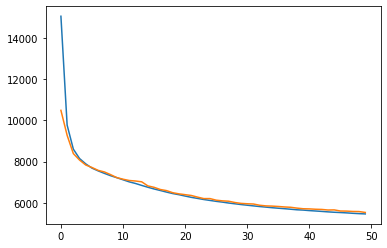

In [12]:
plt.plot(train_trace['loss'])
plt.plot(val_trace['loss'])

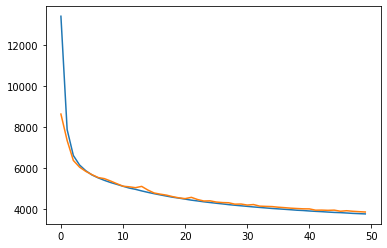

In [13]:
plt.plot(train_trace['mse'])
plt.plot(val_trace['mse'])

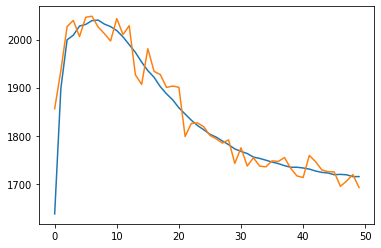

In [14]:
plt.plot(train_trace['kld'])
plt.plot(val_trace['kld'])

In [15]:
img, _ = next(iter(val_data))
print(img.shape)
print(torch.max(img[0]))
print(torch.max(img[0][0]))
print(torch.max(img[0][1]))
print(torch.max(img[0][2]))

torch.Size([128, 3, 96, 96])
tensor(13.5860)
tensor(13.5860)
tensor(4.6773)
tensor(7.0543)


In [16]:
x = img[0:100].to(device)
recon, mu, logvar = model.forward(x)

In [17]:
loss, mse, kld = loss_function(recon, x, mu, logvar)
kld*100

tensor(4872303.5000, device='cuda:0', grad_fn=<MulBackward0>)

In [20]:
torch.sum((-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), axis=1)))

tensor(48723.0352, device='cuda:0', grad_fn=<SumBackward0>)

In [19]:
-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

tensor(48723.0312, device='cuda:0', grad_fn=<MulBackward0>)

In [21]:
mse

tensor(301758.5000, device='cuda:0', grad_fn=<MseLossBackward>)

In [59]:
loss

tensor(60.0141, device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
image_dataset = datasets.ImageFolder(data_dir, transform=transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]))

loader = data.DataLoader(
    image_dataset,
    batch_size=128,
    num_workers=0,
    pin_memory=True,
    shuffle=False
)


mean = 0.
std = 0.
nb_samples = 0.
for dat, _ in loader:
    batch_samples = dat.size(0)
    dat = dat.view(batch_samples, dat.size(1), -1)
    mean += dat.mean(2).sum(0)
    std += dat.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples
print("mean: ", mean)
print("std: ", std)